In [1]:
import json

In [2]:
from importnb import Notebook
with Notebook():
    from quantumsystem import QuantumSystem, qs, System, HyperSystem, IntegerSystem, IntegerArraySystem

In [3]:
class XYLocation(IntegerArraySystem):
    """ Location in XY plane """
    @classmethod
    def validate(cls, terminant):
        if len(terminant) != 2:
            raise Exception(f"Unrecognized terminant: {terminant}")
        return super().validate(terminant)
    
    @classmethod
    def origin(cls):
        return (0, 0)

In [4]:
class Elevation(IntegerSystem):
    """ Elevation from XY plane """

In [5]:
class MovementSpeed(IntegerSystem):
    """ Movement Speed Value """

    class MovementSpeedViolation(Exception):
        """ An exception for moving beyond the MovementSpeed distance """

class JumpJets(System):
    """ Jump Jets """
    
    @classmethod
    def has_jump_jets(cls, entity):
        return cls.get_relationship(entity) == 'j'
    
    @classmethod
    def validate(cls, terminant):
        if terminant not in ['null', 'j']:
            raise Exception(f"Invalid JumpJets terminant: {terminant}")
        return terminant

In [6]:
@JumpJets.sd
@MovementSpeed.sd
class Movement(HyperSystem):
    @classmethod
    def has_jump_jets(cls, entity):
        return JumpJets.has_jump_jets(entity)
    
    @classmethod
    def get_movement_speed(cls, entity):
        return int(MovementSpeed.get_relationship(entity))

In [7]:
@XYLocation.sd
@Elevation.sd
@Movement.sd
class Move(HyperSystem):
    @classmethod
    @Elevation.d
    @XYLocation.d
    @Movement.MovementSpeed.d
    def can_move(cls, entity, delta, movementspeed, xylocation, elevation):
        xyz = json.dumps(xylocation + [elevation])
        deltaDistance = sum([d * d for d in delta]) ** 0.5

        if deltaDistance > movementspeed:
            raise MovementSpeed.MovementSpeedViolation(f"Cannot move unit further ({deltaDistance}) than its movement speed ({movementspeed})")
        return True

    @classmethod
    @Elevation.d
    @XYLocation.d
    @Movement.MovementSpeed.d
    def move(cls, entity, delta, movementspeed, xylocation, elevation):
        xyz = json.dumps(xylocation + [elevation])
        deltaDistance = sum([d * d for d in delta]) ** 0.5

        if deltaDistance > movementspeed:
            raise MovementSpeed.MovementSpeedViolation(f"Cannot move unit further ({deltaDistance}) than its movement speed ({movementspeed})")

        newLocation = [sL + lD for sL, lD in zip(json.loads(xyz), delta)]
        xy = newLocation[:2]
        z = newLocation[2]
        XYLocation.set_relationship(entity, xy)
        Elevation.set_relationship(entity, z)

Initial State


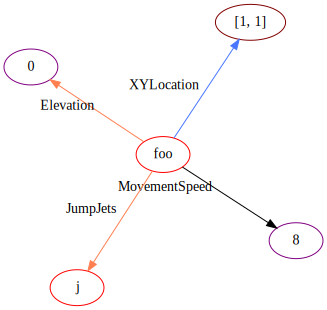

Final State


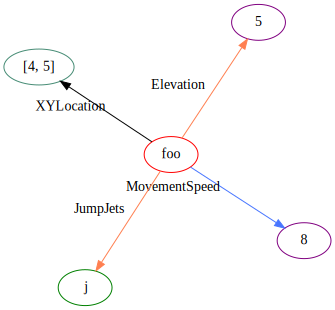

In [8]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()
    Move("foo", XYLocation=[1, 1], Elevation=0, Movement={"MovementSpeed": 8, "JumpJets": "j"})
    assert Movement.has_jump_jets(entity="foo")
    assert Move.entities() == ['foo']
    print("Initial State")
    display(qs.render())
    
    Move.move(entity="foo", delta=[3, 4, 5])
    assert XYLocation.get_relationship("foo") == [4, 5]
    assert Elevation.get_relationship("foo") == 5
    
    try:
        Move.move(entity="foo", delta=[9, 0, 0])
        raise Exception(f"Failed to catch movement speed violation")
    except MovementSpeed.MovementSpeedViolation:
        pass

    print("Final State")
    display(qs.render())